In [1]:
import sys
sys.path.insert(0, "../python")

from propagation import laser
from ionization import ionization
from ionization import adk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import integrate
from scipy.optimize import curve_fit

In [4]:
# Test of a axicon lens
Nx = 2**10
X = 8000
x = np.linspace(-X/2, X/2, Nx, False)
Ny = 2**8
Y = X
y = np.linspace(-Y/2, Y/2, Ny, False)
# z after lens
Nz2 = 2**8
Z2 = 1e6
z2 = np.linspace(0, Z2, Nz2)
# z before lens
Nz1 = int(Nz2/8)
Z1 = Z2/8
z1 = np.linspace(0, Z1, Nz1)

w0 = 2e3
Emax = ionization.field_from_intensity(0.1)
E0 = Emax * np.exp(-(np.reshape(x, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2) / w0**2)

E1 = laser.fourier_prop2(E0, x, y, z1, 1)

alpha = np.radians(0.5)
El = E1[Nz1-1,:] * np.exp(-1j*np.pi*alpha*np.sqrt(np.reshape(x, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2))
E2 = laser.fourier_prop2(El, x, y, z2, 1)

E = np.concatenate((E1, E2[1:, :]))
Z = np.concatenate((z1, z2[1:]+z1[Nz1-1]))

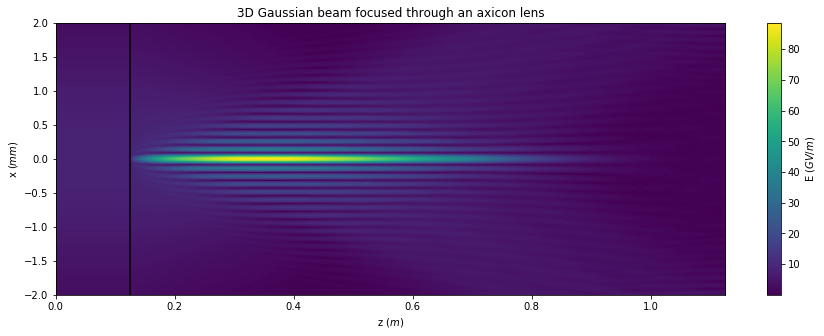

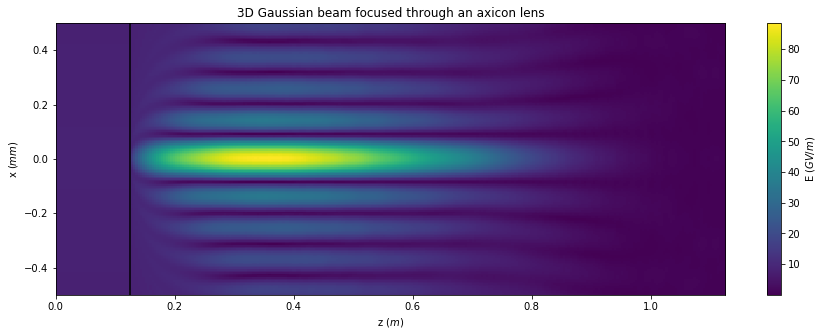

In [5]:
plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(np.transpose(abs(E[:, :, int(Ny/2)]))), aspect='auto', extent=[0, (Z1+Z2)/1e6, -X/2e3, X/2e3])
plt.plot([Z1/1e6, Z1/1e6],[-X/2e3, X/2e3],'k-')
cb = plt.colorbar()
cb.set_label(r'E ($GV/m$)')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('3D Gaussian beam focused through an axicon lens')
plt.xlim([0, (Z1+Z2)/1e6])
plt.ylim([-2, 2])
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(np.transpose(abs(E[:, :, int(Ny/2)]))), aspect='auto', extent=[0, (Z1+Z2)/1e6, -X/2e3, X/2e3])
plt.plot([Z1/1e6, Z1/1e6],[-X/2e3, X/2e3],'k-')
cb = plt.colorbar()
cb.set_label(r'E ($GV/m$)')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('3D Gaussian beam focused through an axicon lens')
plt.xlim([0, (Z1+Z2)/1e6])
plt.ylim([-0.5, 0.5])
plt.show()

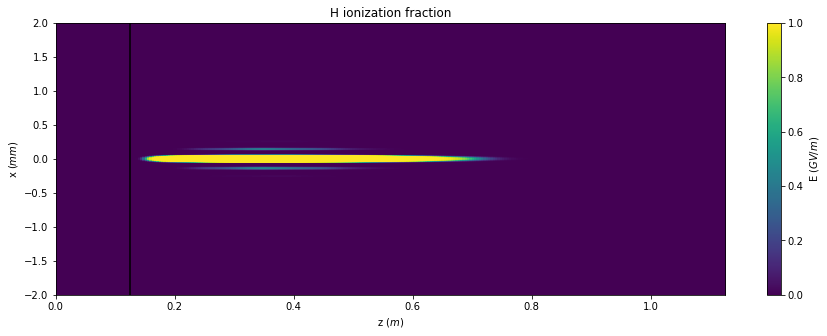

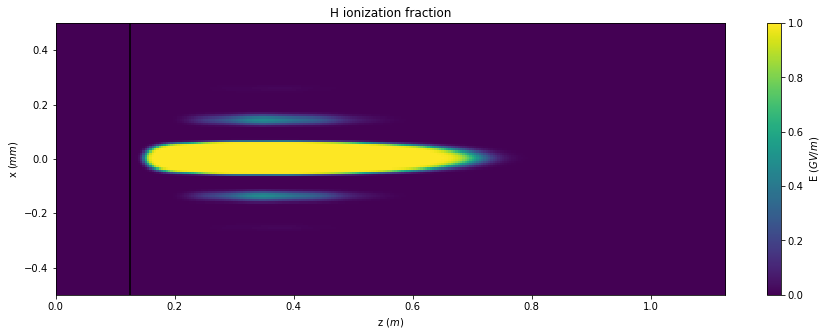

In [4]:
tau = 35.0
frac = adk.gaussian_frac(13.5984, abs(E), tau, 1)

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(np.transpose(frac[:, :, int(Ny/2)])), aspect='auto', extent=[0, (Z1+Z2)/1e6, -X/2e3, X/2e3])
plt.plot([Z1/1e6, Z1/1e6],[-X/2e3, X/2e3],'k-')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('H ionization fraction')
plt.xlim([0, (Z1+Z2)/1e6])
plt.ylim([-2, 2])
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(np.flipud(np.transpose(frac[:, :, int(Ny/2)])), aspect='auto', extent=[0, (Z1+Z2)/1e6, -X/2e3, X/2e3])
plt.plot([Z1/1e6, Z1/1e6],[-X/2e3, X/2e3],'k-')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'x ($mm$)')
plt.title('H ionization fraction')
plt.xlim([0, (Z1+Z2)/1e6])
plt.ylim([-0.5, 0.5])
plt.show()

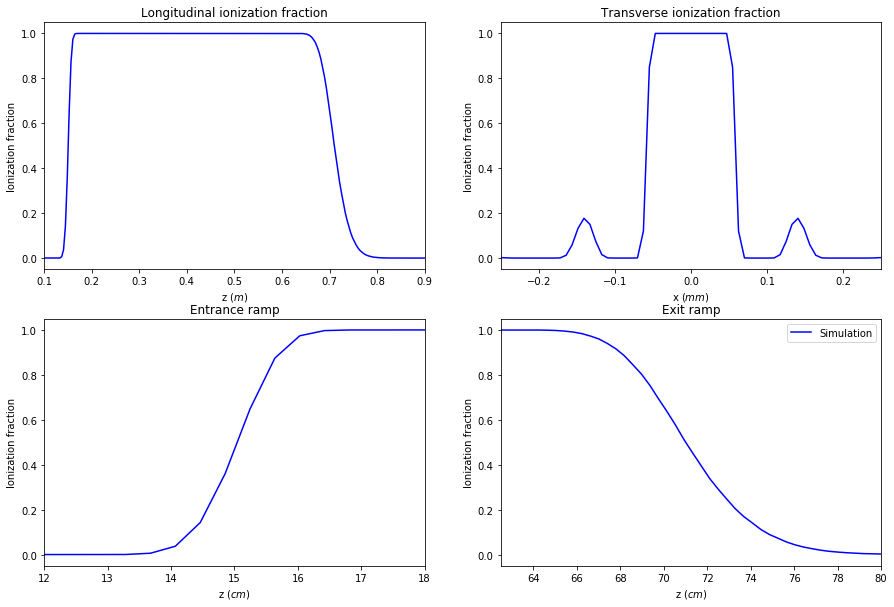

In [59]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(Z/1e6, frac[:, int(Nx/2), int(Ny/2)], 'b-')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'Ionization fraction')
plt.title('Longitudinal ionization fraction')
plt.xlim([0.1, 0.9])

plt.subplot(222)
plt.plot(x/1e3, frac[int(Nz2/4), :, int(Ny/2)], 'b-')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'Ionization fraction')
plt.title('Transverse ionization fraction')
plt.xlim([-0.25, 0.25])

plt.subplot(223)
plt.plot(Z/1e4, frac[:, int(Nx/2), int(Ny/2)], 'b-')
plt.xlabel(r'z ($cm$)')
plt.ylabel(r'Ionization fraction')
plt.title('Entrance ramp')
plt.xlim([12., 18.])



plt.subplot(224)
plt.plot(Z/1e4, frac[:, int(Nx/2), int(Ny/2)], 'b-')
plt.xlabel(r'z ($cm$)')
plt.ylabel(r'Ionization fraction')
plt.title('Exit ramp')
plt.xlim([62.5, 80])
plt.legend(['Simulation', 'Sigmoid', 'Gaussian'])
plt.show()

Sigmoid (z0, sigma):  [ 58.93402262   6.08843632]
Gaussian (z0, sigma):  [ 66.3131861    3.95055315]


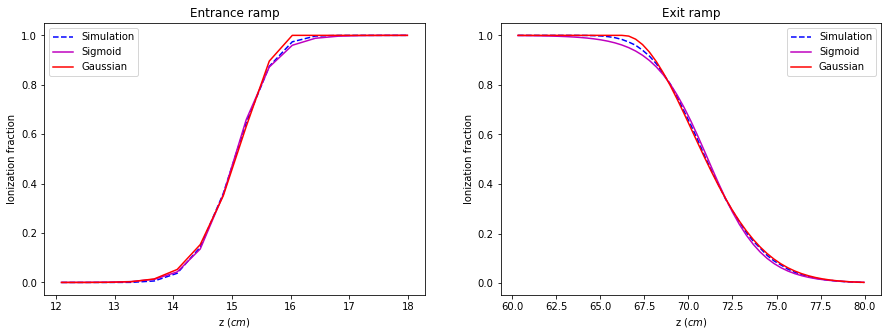

In [73]:
# Curve fitting
def sigmoidE(z, z0, sigma):
    return 1/(1 + np.exp(4*(-z+z0-2*sigma)/sigma))

def gaussianE(z, z0, sigma):
    ret = np.zeros(np.shape(z))
    ret[(z-z0) > 0] = 1.0
    ret[(z-z0) <= 0] = np.exp(-(z[(z-z0) <= 0]-z0)**2/(2*sigma**2))
    return ret

def sigmoidX(z, z0, sigma):
    return 1/(1 + np.exp(4*(z-z0-2*sigma)/sigma))

def gaussianX(z, z0, sigma):
    ret = np.zeros(np.shape(z))
    ret[(z-z0) < 0] = 1.0
    ret[(z-z0) >= 0] = np.exp(-(z[(z-z0) >= 0]-z0)**2/(2*sigma**2))
    return ret

# Arrays for entrance and exit
# Entrance array
sel = np.array(Z < 18e4) * np.array(Z > 12e4)
zEnt = Z[sel]
fracEnt = frac[sel, int(Nx/2), int(Ny/2)]
# Exit array
sel = np.array(Z < 80e4) * np.array(Z > 60e4)
zExit = Z[sel]
fracExit = frac[sel, int(Nx/2), int(Ny/2)]

# Entrance fits
sigmoidEPopt, sigmoidEPcov = curve_fit(sigmoidE, zEnt, fracEnt, p0=[20e4, 1e4])
gaussianEPopt, gaussianEPcov = curve_fit(gaussianE, zEnt, fracEnt, p0=[17e4, 1e4])
# Exit fits
sigmoidXPopt, sigmoidXPcov = curve_fit(sigmoidX, zExit, fracExit, p0=[80e4, 10e4])
gaussianXPopt, gaussianXPcov = curve_fit(gaussianX, zExit, fracExit, p0=[64e4, 5e4])

print('Sigmoid (z0, sigma): ', sigmoidXPopt/1e4)
print('Gaussian (z0, sigma): ', gaussianXPopt/1e4)

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(zEnt/1e4, fracEnt, 'b--', zEnt/1e4, sigmoidE(zEnt, *sigmoidEPopt), 'm-',
        zEnt/1e4, gaussianE(zEnt, *gaussianEPopt), 'r-')
plt.xlabel(r'z ($cm$)')
plt.ylabel(r'Ionization fraction')
plt.title('Entrance ramp')
plt.legend(['Simulation', 'Sigmoid', 'Gaussian'])

plt.subplot(122)
plt.plot(zExit/1e4, fracExit, 'b--', zExit/1e4, sigmoidX(zExit, *sigmoidXPopt), 'm-',
        zExit/1e4, gaussianX(zExit, *gaussianXPopt), 'r-')
plt.xlabel(r'z ($cm$)')
plt.ylabel(r'Ionization fraction')
plt.title('Exit ramp')
plt.legend(['Simulation', 'Sigmoid', 'Gaussian'])
plt.show()